# Loading Libraries

In [19]:
# Pandas & Numpy
import pandas as pd
import numpy as np 

# Visualization
import seaborn as sns 
from matplotlib import pyplot as plt 

# Tensorflow
import tensorflow as tf
from tensorflow import keras 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k,
    ndcg_at_k,
    map_at_k
)
from sklearn.metrics import accuracy_score 

# Recomender Utilities
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.split_utils import min_rating_filter_pandas

# Standard VAE Model
from recommenders.models.vae.standard_vae import StandardVAE

# System & OS
import sys
import os

# Turn of Warnings for Readability 
import warnings
warnings.filterwarnings("ignore")

# Import & Read Dataset

In [20]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/rec_sys_ratings_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/rec_sys_ratings_test.csv", index_col=0)

In [21]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (393208, 3)
Shape of Test: 	 (98401, 3)


In [22]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3011
Unique Users in Test: 3011
Unique Items in Train: 2318
Unique Items in Test: 2318


In [23]:
# Concatenate both Dataset again for further Data Preparation
df = pd.concat([train, test], axis=0)

In [24]:
# Change name of columns 
df = df.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})
df.columns

Index(['itemID', 'userID', 'rating'], dtype='object')

# Data Filtering 

In [25]:
# Binarize the data (only keep ratings >= 0.5)
df_preferred = df[df['rating'] > 0]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 0]


# Head of df_preferred
df_preferred.head(10)

(172306, 3)


,itemID,userID,rating
1750,16169E,16607,1
7870,20829,17888,1
156219,84030E,15443,1
101909,22810,18018,1
50506,22090,16774,2
33650,21745,13719,1
160104,84725,17068,1
61109,22281,16655,1
169295,85123A,14022,1
13204,21094,14541,1


In [26]:
# Head of df_low_rating
df_low_rating.head(10)

,itemID,userID,rating
444302,22326,14323,-1
411656,23208,15147,-1
302355,23301,12580,-1
375871,20723,12744,-1
309068,20719,17554,-1
431970,84992,18231,-1
438221,21790,14553,-1
203598,POST,14198,-2
295108,22457,15578,-2
393963,85152,16012,-1


In [27]:
# Keep users who clicked on at least 5 items
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [28]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d interactions between %d users and %d items (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 172306 interactions between 3011 users and 2318 items (sparsity: 2.469%)


# Split Data

In [29]:
unique_users = sorted(df.userID.unique())
np.random.seed(1)
unique_users = np.random.permutation(unique_users)

In [30]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - 602 * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - 602 * 2) : (n_users - 602)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - 602):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 3011

Number of training users: 1807

Number of validation users: 602

Number of test users: 602


In [31]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])


Number of training observations:  104320

Number of validation observations:  34869

Number of test observations:  33117


In [32]:
# Obtain list of unique items used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique items that consumed in training set", unique_train_items.size)

Number of unique items that consumed in training set 2318


In [33]:
# For validation set keep only items that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies items used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  34869

Number of test observations after filtering:  33117


In [34]:
test_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0])

0.19219876266641905

# Click Matrix Generation

In [35]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [36]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(1807, 2318)
(602, 2318)
(602, 2318)


In [37]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=1)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=1)

In [38]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=0.5)
val_data = binarize(a=val_data, threshold=0.5)
test_data = binarize(a=test_data, threshold=0.5)

In [39]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=0.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=0.5)

In [40]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=0.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=0.5)

# Shapes & Dimensions after Data Preparation

In [57]:
# Interactions per Dataset
print("Interatons in the Training Set: ",train_set.shape[0])
print("Interatons in the Validation Set: ",val_set.shape[0])
print("Interatons in the Test Set: ",test_set.shape[0])

Interatons in the Training Set:  104320
Interatons in the Validation Set:  34869
Interatons in the Test Set:  33117


In [59]:
# Percentages of Interactions per Dataset 
print("Percentage Training: " ,train_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0]))
print("Percentage Validation: " ,val_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0]))
print("Percentage Test: " ,test_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0]))

Percentage Training:  0.6054345176604413
Percentage Validation:  0.20236671967313966
Percentage Test:  0.19219876266641905


In [61]:
# Interactions in Train & Test of Val & Test 
print("Interactions in Validation Training",val_data_tr.sum())
print("Interactions in Validation Test",val_data_te.sum())
print("Interactions in Test Training",test_data_tr.sum())
print("Interactions in Test Test",test_data_te.sum())

Interactions in Validation Training 26162.0
Interactions in Validation Test 8707.0
Interactions in Test Training 24851.0
Interactions in Test Test 8266.0


In [41]:
np.unique(test_data_tr)

array([0., 1.])

In [42]:
np.unique(train_data)

array([0., 1.])

In [43]:
np.unique(val_data)

array([0., 1.])

In [44]:
np.unique(val_data_tr)

array([0., 1.])

In [45]:
np.unique(test_data_te_ratings)

array([0, 1, 2])

In [46]:
np.unique(val_data_te_ratings)

array([0, 1, 2])

# Hyperparameter Tuning

In [47]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [48]:
from tempfile import TemporaryDirectory

tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir.name, "svae_weights.hdf5")

In [49]:
# Set up Parameters
intermediate_dimension = [600, 800, 1000, 1200, 1400] 
latent_dimension = [50, 70, 90] 
batch_sizes = [25, 50]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = StandardVAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

2023-06-12 20:37:48.993443: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 20:37:49.006232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  25 Annealing:  True :	 0.10120830625837317
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  25 Annealing:  True :	 0.15346690590279077
Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  25 Annealing:  False :	 0.07401323709564257
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  25 Annealing:  False :	 0.11541262401455295
Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.06798554927912821
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.11038174475393063
Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.06589545484713327
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.10975479299205898
Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  25 Annealing:  True :	 0.08907501442716473
Recall@20 for I

In [50]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_initial = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_initial.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
36,1200,50,True,25,0.120807,0.180971,0.146844,0.113289
48,1400,50,True,25,0.116234,0.177078,0.143355,0.111213
32,1000,90,True,25,0.108794,0.170564,0.133555,0.107143
50,1400,50,True,50,0.102502,0.154914,0.131229,0.100000
12,800,50,True,25,0.102439,0.153132,0.127575,0.100581
0,600,50,True,25,0.101208,0.153467,0.130066,0.096429
24,1000,50,True,25,0.100717,0.156457,0.129402,0.102824
18,800,70,True,50,0.098047,0.149447,0.131229,0.099834
40,1200,70,True,25,0.091170,0.145966,0.121595,0.094518
37,1200,50,False,25,0.090805,0.137147,0.121096,0.093771


In [51]:
# Check Average Performance of Latent Dimensions
df_tuning_initial.groupby("latent_dimensions")['recall@10'].mean()

latent_dimensions
50    0.087695
70    0.080740
90    0.078705
Name: recall@10, dtype: float64

# Hyperparameter Tuning 2.0 

In [54]:
# Set up Parameters
intermediate_dimension = [1100, 1200, 1300, 1400, 1500] 
latent_dimension = [30, 40, 50, 60, 70] 
batch_sizes = [25]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = StandardVAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

Recall@10 for Intermediate Dim:  1100 Latent Dim:  30 Batch size:  25 Annealing:  True :	 0.12046654787821437
Recall@20 for Intermediate Dim:  1100 Latent Dim:  30 Batch size:  25 Annealing:  True :	 0.18001688820085504
Recall@10 for Intermediate Dim:  1100 Latent Dim:  30 Batch size:  25 Annealing:  False :	 0.09223510055140842
Recall@20 for Intermediate Dim:  1100 Latent Dim:  30 Batch size:  25 Annealing:  False :	 0.13889537298681834
Recall@10 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  25 Annealing:  True :	 0.09110497786416374
Recall@20 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  25 Annealing:  True :	 0.1445892959702186
Recall@10 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  25 Annealing:  False :	 0.09017451573803979
Recall@20 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  25 Annealing:  False :	 0.1399934799181818
Recall@10 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  25 Annealing:  True :	 0.09392203217810009
Recall@2

In [55]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
38,1400,70,True,25,0.126609,0.179059,0.152159,0.112791
18,1200,70,True,25,0.123641,0.181347,0.148671,0.112791
30,1400,30,True,25,0.123011,0.181813,0.150831,0.113704
0,1100,30,True,25,0.120467,0.180017,0.147342,0.111130
24,1300,50,True,25,0.120466,0.186075,0.150831,0.115781
6,1100,60,True,25,0.118177,0.167881,0.145349,0.108970
20,1300,30,True,25,0.114449,0.173232,0.142857,0.108555
32,1400,40,True,25,0.112077,0.165487,0.138206,0.104568
8,1100,70,True,25,0.105798,0.157089,0.133223,0.101578
10,1200,30,True,25,0.104931,0.158271,0.134385,0.101080


# Visualization of Hyperparameter Tuning

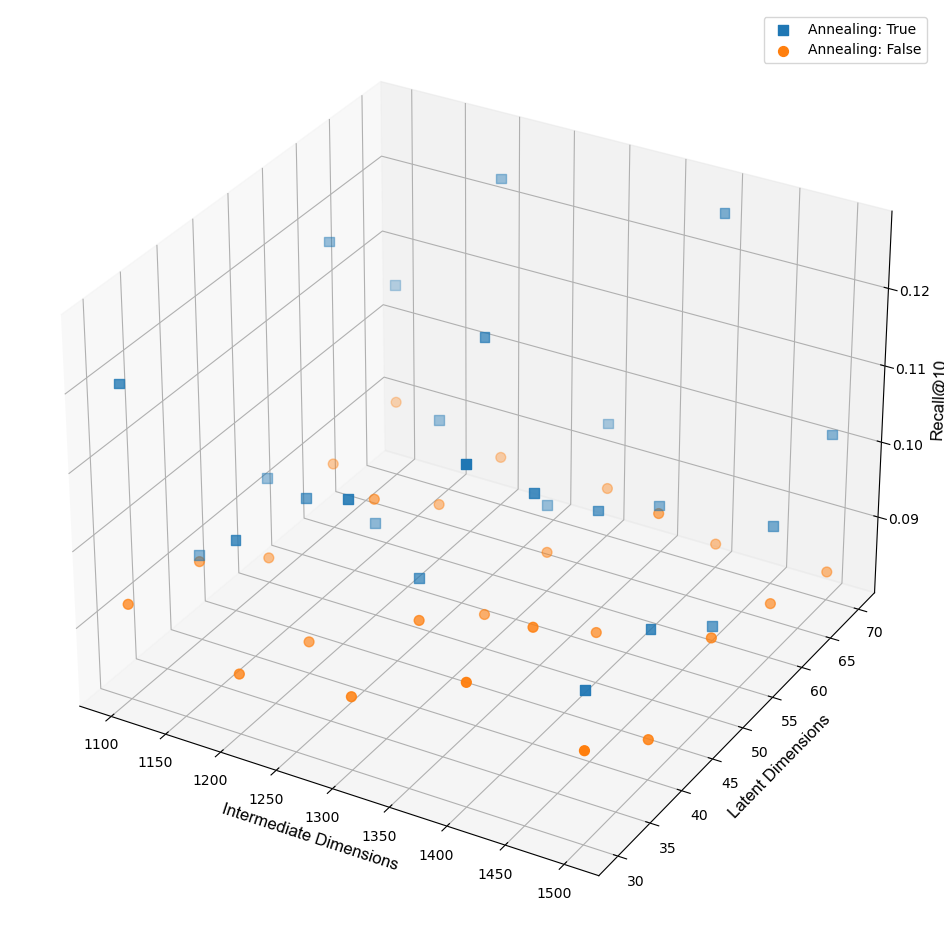

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 12))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x = df_tuning_2.intermediate_dimensions
y = df_tuning_2['latent_dimensions']
z = df_tuning_2['recall@10']
annealing = df_tuning_2['annealing']

ax.set_xlabel('Intermediate Dimensions', fontname='Arial', fontsize=12)
ax.set_ylabel('Latent Dimensions', fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10', fontname='Arial', fontsize=12)

# Define different marker shapes based on the annealing values
marker_shapes = ['o', 's'] 

# Iterate over unique annealing values and plot each separately
for annealing_value in annealing.unique():
    indices = annealing == annealing_value
    ax.scatter(
        x[indices],
        y[indices],
        z[indices],
        marker=marker_shapes[annealing_value],
        s=50,
        label=f'Annealing: {annealing_value}'
    )

# Add a legend
ax.legend()

plt.show()
